In [1]:
import tensorflow as tf
import numpy as np
import time
import pandas as pd
import math
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

# set random seed
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

tf.compat.v1.disable_eager_execution()

# Initializing wandb functionality

In [2]:
!wandb login --relogin
# Copy and paste this api key: 822244d22c29151b0b6501c81c4e22a5c5a0843f

entity_name="vamsi_malineni6"
project_name="bc_pinn_ship_data"

wandb.init(entity=entity_name,project=project_name)
# Finish the dummy run started after first initializing
wandb.run.finish()

# # Delete the dummy run from the wandb workspace 
# api=wandb.Api()
# run_id=wandb.run.id
# run=ap.run(str(entity_name)+"/"+str(project_name)+"/"+str(run_id))
# run.delete()

'wandb' is not recognized as an internal or external command,
operable program or batch file.
wandb: Currently logged in as: vamsi_malineni6. Use `wandb login --relogin` to force relogin


In [17]:
class bc_pinn_t0:
    # Initialize the class
    def __init__(self,domain,initial,boundary,domaindata,datalist,
                 ntrain,batch_size,layers,re,
                 load_model=False,filedr='',timestep=0,
                 savewandb=''):
        
        self.domain   = domain
        self.initial  = initial
        self.boundary = boundary
        self.datalist = datalist
        self.domain_data = domaindata
        
        self.time_step = timestep
        
        self.params_name = savewandb
        
        self.ntrain = ntrain
        self.batch_size= batch_size
        
        # Calling domain data for initializing the neural network before entering the Adam optimization
        self.xa=self.domain_data[:,0].reshape(self.domain_data[:,0].shape[0],1)
        self.ya=self.domain_data[:,1].reshape(self.domain_data[:,1].shape[0],1)
        self.za=self.domain_data[:,2].reshape(self.domain_data[:,2].shape[0],1)
        self.ta=self.domain_data[:,3].reshape(self.domain_data[:,3].shape[0],1)
        
        self.ua=self.domain_data[:,4].reshape(self.domain_data[:,4].shape[0],1)
        self.va=self.domain_data[:,5].reshape(self.domain_data[:,5].shape[0],1)
        self.wa=self.domain_data[:,6].reshape(self.domain_data[:,6].shape[0],1)
        
        
        X = np.concatenate([self.xa,self.ya,self.za,self.ta], 1)

        self.lowb = X.min(0) 
        self.upb = X.max(0)
        
        # Calling boundary and initial conditions data as they dont change through the adam iterations
                
        self.x0=self.initial[:,0].reshape(self.initial[:, 0].shape[0], 1)
        self.y0=self.initial[:,1].reshape(self.initial[:, 1].shape[0], 1)
        self.z0=self.initial[:,2].reshape(self.initial[:, 2].shape[0], 1)
        self.t0=self.initial[:,3].reshape(self.initial[:, 3].shape[0], 1)
        self.u0=self.initial[:,4].reshape(self.initial[:, 4].shape[0], 1)
        self.v0=self.initial[:,5].reshape(self.initial[:, 5].shape[0], 1)
        self.w0=self.initial[:,6].reshape(self.initial[:, 6].shape[0], 1)
        
        self.xb=self.boundary[:,0].reshape(self.boundary[:, 0].shape[0], 1)
        self.yb=self.boundary[:,1].reshape(self.boundary[:, 1].shape[0], 1)
        self.zb=self.boundary[:,2].reshape(self.boundary[:, 2].shape[0], 1)
        self.tb=self.boundary[:,3].reshape(self.boundary[:, 3].shape[0], 1)
        self.ub=self.boundary[:,4].reshape(self.boundary[:, 4].shape[0], 1)
        self.vb=self.boundary[:,5].reshape(self.boundary[:, 5].shape[0], 1)
        self.wb=self.boundary[:,6].reshape(self.boundary[:, 6].shape[0], 1)
        
  
        self.layers = layers
        self.re = re

        # Initialize NN
        if load_model ==False:
            self.weights, self.biases = self.initialize_NN(self.layers)
        else:
            self.weights,self.biases = self.load_parameters(filedr,self.layers)
            
        

        # tf placeholders and graph
        
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])
        
        # Initial conditions placeholders
        self.x_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.z_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.z0.shape[1]])
        self.t_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        self.w_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.w0.shape[1]])
        
        # Boundary conditions placeholders
        self.x_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xb.shape[1]])
        self.y_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.yb.shape[1]])
        self.z_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.zb.shape[1]])
        self.t_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.tb.shape[1]])
        
        self.u_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ub.shape[1]])
        self.v_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.vb.shape[1]])
        self.w_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.wb.shape[1]])
        
        # Domain placeholders having the size of batch_size
        self.x_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.y_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.z_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.za.shape[1]])
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])
        
        # Domain data placeholders 
        self.xdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.ydata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.zdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.za.shape[1]])
        self.tdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])
        
        self.udata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ua.shape[1]])
        self.vdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.va.shape[1]])
        self.wdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.wa.shape[1]])
        
        # Initial conditions predictions
        self.u_ini_pred, self.v_ini_pred, self.w_ini_pred, self.p_ini_pred =\
            self.net_NS(self.x_ini_tf, self.y_ini_tf, self.z_ini_tf, self.t_ini_tf)
        
        # Boundary conditions predictions
        self.u_boundary_pred, self.v_boundary_pred, self.w_boundary_pred, self.p_boundary_pred = \
            self.net_NS(self.x_boundary_tf, self.y_boundary_tf, self.z_boundary_tf, self.t_boundary_tf)
        
        # Domain data predictions
        self.u_dom_pred,self.v_dom_pred,self.w_dom_pred,_=\
            self.net_NS(self.xdata_tf,self.ydata_tf,self.zdata_tf,self.tdata_tf)
        
        # Domain predictions
        self.u_pred, self.v_pred, self.w_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_w_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.z_tf, self.t_tf)

        alpha, beta = 1, 1

        # set loss function
        self.initial_loss  = alpha * tf.reduce_mean(input_tensor=tf.square(self.u_ini_tf - self.u_ini_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.v_ini_tf - self.v_ini_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.w_ini_tf - self.w_ini_pred))
        
        self.boundary_loss = beta * tf.reduce_mean(input_tensor=tf.square(self.u_boundary_tf - self.u_boundary_pred)) + \
                             beta * tf.reduce_mean(input_tensor=tf.square(self.v_boundary_tf - self.v_boundary_pred)) + \
                             beta * tf.reduce_mean(input_tensor=tf.square(self.w_boundary_tf - self.w_boundary_pred))

        self.domdata_loss  = alpha * tf.reduce_mean(input_tensor=tf.square(self.udata_tf - self.u_dom_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.vdata_tf - self.v_dom_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.wdata_tf - self.w_dom_pred))

        self.residual_loss = tf.reduce_mean(input_tensor=tf.square(self.f_u_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_v_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_w_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_e_pred))

        
        
        self.loss =  self.initial_loss + self.boundary_loss + self.residual_loss + self.domdata_loss
        
        self.loss_i=[]
        self.loss_b=[]
        self.loss_r=[]
        self.loss_d=[]

        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)
        

#===========================================================================================================#
#====================================Transfer Learning======================================================#
#===========================================================================================================#
    def save_parameters(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
                       
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Ship_data_params\exp1")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([weights,biases],f)
            print("Parameters are saved in pickle file")

    def load_parameters(self,fileDr,layers):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Ship_data_params\exp1")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            weights,biases=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable, with few of the layers frozen for trainin
        for num in range(0,num_layers-1):
                tf_weights.append ( tf.Variable (weights[num],trainable ='True'))
                tf_biases.append  ( tf.Variable (biases[num],trainable ='True' ))
        
        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases
    
    
#===========================================================================================================#
#===========================================================================================================#
#===========================================================================================================#
 

# initialize the weight and bias
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# generate the neural network
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
#             H = tf.tanh(tf.add(tf.matmul(H, W), b))
            H = tf.keras.activations.swish(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

# ###################without assume###############
    # supervised data driven
    def net_NS(self, x, y, z, t):

        u_v_p = self.neural_net(tf.concat([x, y, z, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        w = u_v_p[:, 2:3]
        p = u_v_p[:, 3:4]

        return u, v, w, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, z, t):

        u_v_p = self.neural_net(tf.concat([x, y, z, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        w = u_v_p[:, 2:3]
        p = u_v_p[:, 3:4]

        u_t = tf.gradients(ys=u, xs=t)[0] 
        u_x = tf.gradients(ys=u, xs=x)[0] 
        u_y = tf.gradients(ys=u, xs=y)[0] 
        u_z = tf.gradients(ys=u, xs=z)[0] 
        u_xx = tf.gradients(ys=u_x, xs=x)[0] 
        u_yy = tf.gradients(ys=u_y, xs=y)[0] 
        u_zz = tf.gradients(ys=u_z, xs=z)[0] 
        
        v_t = tf.gradients(ys=v, xs=t)[0] 
        v_x = tf.gradients(ys=v, xs=x)[0] 
        v_y = tf.gradients(ys=v, xs=y)[0] 
        v_z = tf.gradients(ys=v, xs=z)[0] 
        v_xx = tf.gradients(ys=v_x, xs=x)[0] 
        v_yy = tf.gradients(ys=v_y, xs=y)[0] 
        v_zz = tf.gradients(ys=v_z, xs=z)[0] 
        
        w_t = tf.gradients(ys=w, xs=t)[0] 
        w_x = tf.gradients(ys=w, xs=x)[0] 
        w_y = tf.gradients(ys=w, xs=y)[0] 
        w_z = tf.gradients(ys=w, xs=z)[0] 
        w_xx = tf.gradients(ys=w_x, xs=x)[0] 
        w_yy = tf.gradients(ys=w_y, xs=y)[0] 
        w_zz = tf.gradients(ys=w_z, xs=z)[0] 
        
        p_x = tf.gradients(ys=p, xs=x)[0] 
        p_y = tf.gradients(ys=p, xs=y)[0]
        p_z = tf.gradients(ys=p, xs=z)[0] 

        f_u = u_t + (u * u_x + v * u_y + w * u_z) + p_x - (1/self.re) * (u_xx + u_yy + u_zz)
        f_v = v_t + (u * v_x + v * v_y + w * v_z) + p_y - (1/self.re) * (v_xx + v_yy + v_zz)
        f_w = w_t + (u * w_x + v * w_y + w * w_z) + p_y - (1/self.re) * (w_xx + w_yy + w_zz)
        f_e = u_x + v_y + w_z

        return u, v, w, p, f_u, f_v, f_w, f_e

#===========================================================================================================#
#===========================Predicting and finding error every 10 epochs====================================#
#===========================================================================================================#
   
    
    def predict(self, x_star, y_star, z_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.z_tf: z_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        w_star = self.sess.run(self.w_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, w_star, p_star
    
    def build_timesteps_domain(self,test_path):
        name=r'\domain.csv'
        t=pd.read_csv(test_path+name).to_numpy()
        # print(t)

        # Code to extract time steps in a time segment as a list.
        time_steps=[]

        # time_seg=1
        c,v=np.unique(t[:,3],return_counts=True)

        def sum_sizes(sizes):
            return sum(sizes)

        sizes=[]
        ed=[]
        for i in range(len(v)):
            if i ==0:
                time_steps.append(t[0:v[i],:])
                sizes.append(time_steps[i].shape[0])
            else:
                start=sum_sizes(sizes)
                end=start+v[i]
                time_steps.append(t[start:end,:])
                sizes.append(time_steps[i].shape[0])

        return time_steps

    def load_testdata(self,time_step):
        
        test_path=r"E:\Vamsi_oe20s302\Original Ship Simulation\Final Testing combine"
        tsd=self.build_timesteps_domain(test_path)
        
        if time_step==0:
            ts=0
        # this step ensures that only the final timestep of the time segment is sent for prediction
        else:
            ts=int(time_step*100-1)
            
        domain=tsd[ts]
        x_star=domain[:,0].reshape(domain[:,0].shape[0],1)
        y_star=domain[:,1].reshape(domain[:,1].shape[0],1)
        z_star=domain[:,2].reshape(domain[:,2].shape[0],1)
        t_star=domain[:,3].reshape(domain[:,3].shape[0],1)

        u_star=domain[:,4].reshape(domain[:,4].shape[0],1)
        v_star=domain[:,5].reshape(domain[:,5].shape[0],1)
        w_star=domain[:,6].reshape(domain[:,6].shape[0],1)

        X_star=[x_star,y_star,z_star,t_star]
        Y_star=[u_star,v_star,w_star]

        return X_star,Y_star
    
    def find_error(self,test_time_step):
        
        X_star,Y_star=self.load_testdata(test_time_step)
        u_pred,v_pred,w_pred,_ = self.predict(X_star[0],X_star[1],X_star[2],X_star[3])
        
        error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
        error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)
        error_w = np.linalg.norm(Y_star[2] - w_pred, 2) / np.linalg.norm(Y_star[2], 2)
        

        return error_u,error_v,error_w
        
#===========================================================================================================#
#===========================ADAM TRAINING FUNCTION==========================================================#
#===========================================================================================================#
   

    def Adam_train(self, epoch=5000, learning_rate=1e-3):
    
        start_time = time.time()
        
        iters = int(self.ntrain / self.batch_size)
        
        for it in range(epoch):
            
            for i in (range(iters)):
            
                idx=  np.random.choice(self.domain.shape[0],self.batch_size,replace=False)
                didx= np.random.choice(self.domain_data.shape[0],100,replace=False)
                
                self.data_domain=self.domain[idx,:]
                self.data_driven=self.domain_data[didx,:]
                
                xd=self.data_domain[:,0].reshape(self.data_domain[:, 0].shape[0], 1)
                yd=self.data_domain[:,1].reshape(self.data_domain[:, 1].shape[0], 1)
                zd=self.data_domain[:,2].reshape(self.data_domain[:, 2].shape[0], 1)
                td=self.data_domain[:,3].reshape(self.data_domain[:, 3].shape[0], 1)

                xdata=self.data_driven[:,0].reshape(self.data_driven[:, 0].shape[0], 1)
                ydata=self.data_driven[:,1].reshape(self.data_driven[:, 1].shape[0], 1)
                zdata=self.data_driven[:,2].reshape(self.data_driven[:, 2].shape[0], 1)
                tdata=self.data_driven[:,3].reshape(self.data_driven[:, 3].shape[0], 1)
                
                udata=self.data_driven[:,4].reshape(self.data_driven[:, 4].shape[0], 1)
                vdata=self.data_driven[:,5].reshape(self.data_driven[:, 5].shape[0], 1)
                wdata=self.data_driven[:,6].reshape(self.data_driven[:, 6].shape[0], 1)
                    
                Xd = np.concatenate([xd,yd,td], 1)
                
                # In contrast the model would see 10000 initial data points every iteration and every epoch
                # The model would see 1584 boundary conditions points every iteration and every epoch
                
                tf_dict = {self.x_ini_tf: self.x0, 
                           self.y_ini_tf: self.y0,
                           self.z_ini_tf: self.z0,
                           self.t_ini_tf: self.t0, 
                           self.u_ini_tf: self.u0,
                           self.v_ini_tf: self.v0,
                           self.w_ini_tf: self.w0,
                           
                           self.x_boundary_tf: self.xb,
                           self.y_boundary_tf: self.yb, 
                           self.z_boundary_tf: self.zb,
                           self.t_boundary_tf: self.tb,
                           self.u_boundary_tf: self.ub, 
                           self.v_boundary_tf: self.vb,
                           self.w_boundary_tf: self.wb,
                           
                           self.x_tf: xd, 
                           self.y_tf: yd, 
                           self.z_tf: zd,
                           self.t_tf: td,
                           
                           self.xdata_tf: xdata, 
                           self.ydata_tf: ydata, 
                           self.zdata_tf: zdata,
                           self.tdata_tf: tdata,
                           self.udata_tf: udata,
                           self.vdata_tf: vdata,
                           self.wdata_tf: wdata,
                           
                           self.learning_rate: learning_rate}

                self.sess.run(self.train_op_Adam, tf_dict)
            
            if it % 10 == 0:
                
                elapsed = time.time() - start_time
                
                t_loss= self.sess.run(self.loss, tf_dict)
                i_loss= self.sess.run(self.initial_loss,tf_dict)
                b_loss= self.sess.run(self.boundary_loss,tf_dict)
                r_loss= self.sess.run(self.residual_loss,tf_dict)
                d_loss= self.sess.run(self.domdata_loss,tf_dict)
                
                # Finding the error value at given timestep for every 10 epochs
                checking_timestep = np.unique(self.domain[:,3])[-1]
                
                eu1,ev1,ew1= self.find_error(checking_timestep)
#                 eu2= self.find_error(2)
#                 eu3= self.find_error(3)
#                 eu4= self.find_error(4)
#                 eu5= self.find_error(5)
#                 eu6= self.find_error(6)
#                 eu7= self.find_error(7)

                
                # Logging the loss values and error values to wandb workspace:
                log_dict={"Total_loss":t_loss,"Initial_loss":i_loss,\
                         "Boundary_loss":b_loss,"Residual_loss":r_loss,\
                         "Data_loss":d_loss,\
                          "u_error_time step 1":eu1,\
                          "v_error_time step 1":ev1,\
                          "w_error_time step 1":ew1
#                           "time step 2":eu2,\
#                           "time step 3":eu3,\
#                           "time step 4":eu4,\
#                           "time step 5":eu5,\
#                           "time step 6":eu6,\
#                           "time step 7":eu7
                         }
                
                wandb.log(log_dict)
                
                print('epochs: %d, Loss: %.3e, Time: %.2f' %
                      (it, t_loss, elapsed))
                
                start_time = time.time()
            
            if it % 1000 == 0 and it > 0:
                self.save_parameters(self.params_name)
                




# This code snippet is for training for timesegments other than initial one

In [19]:
class bc_pinn_t:
    # Initialize the class
    def __init__(self,domain,initial,boundary,domaindata,prevtimedata,datalist,
                 ntrain,batch_size,layers,re,
                 load_model=False,filedr='',timestep=0
                 ,savewandb=''):
        
        self.domain   = domain
        self.initial  = initial
        self.boundary = boundary
        self.domain_data = domaindata
        self.prev_data = prevtimedata
        self.datalist = datalist
        
        self.time_step = timestep
        
        self.params_name = savewandb
        
        self.ntrain = ntrain
        self.batch_size= batch_size
        #=========================================================================================================#
        
        # Calling domain data for initializing the neural network before entering the Adam optimization
        self.xa=self.domain[:,0].reshape(self.domain[:,0].shape[0],1)
        self.ya=self.domain[:,1].reshape(self.domain[:,1].shape[0],1)
        self.za=self.domain[:,2].reshape(self.domain[:,2].shape[0],1)
        self.ta=self.domain[:,3].reshape(self.domain[:,3].shape[0],1)
        self.ua=self.domain[:,4].reshape(self.domain[:,4].shape[0],1)
        self.va=self.domain[:,5].reshape(self.domain[:,5].shape[0],1)
        self.wa=self.domain[:,6].reshape(self.domain[:,6].shape[0],1)
        
        # This creates an array of collocation points only for the domain
        X = np.concatenate([self.xa,self.ya,self.ta], 1)
        self.lowb = X.min(0) 
        self.upb = X.max(0)
        
        #=========================================================================================================#
        
        # Calling boundary and initial conditions data as they dont change through the adam iterations
                
        self.x0=self.initial[:,0].reshape(self.initial[:, 0].shape[0], 1)
        self.y0=self.initial[:,1].reshape(self.initial[:, 1].shape[0], 1)
        self.z0=self.initial[:,2].reshape(self.initial[:, 2].shape[0], 1)
        self.t0=self.initial[:,2].reshape(self.initial[:, 3].shape[0], 1)
        self.u0=self.initial[:,3].reshape(self.initial[:, 4].shape[0], 1)
        self.v0=self.initial[:,4].reshape(self.initial[:, 5].shape[0], 1)
        
        self.xb=self.boundary[:,0].reshape(self.boundary[:, 0].shape[0], 1)
        self.yb=self.boundary[:,1].reshape(self.boundary[:, 1].shape[0], 1)
        self.zb=self.boundary[:,2].reshape(self.boundary[:, 2].shape[0], 1)
        self.tb=self.boundary[:,3].reshape(self.boundary[:, 3].shape[0], 1)
        self.ub=self.boundary[:,4].reshape(self.boundary[:, 4].shape[0], 1)
        self.vb=self.boundary[:,5].reshape(self.boundary[:, 5].shape[0], 1)
        self.wb=self.boundary[:,6].reshape(self.boundary[:, 6].shape[0], 1)
        
  
        self.layers = layers
        self.re = re

        # Initialize NN
        if load_model ==False:
            self.weights, self.biases = self.initialize_NN(self.layers)
        else:
            self.weights,self.biases = self.load_parameters(filedr,self.layers,self.freeze)
            
        

        # tf placeholders and graph
        
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])
        
        # Initial conditions placeholders
        self.x_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.z_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.z0.shape[1]])
        self.t_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        self.w_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.w0.shape[1]])
        
        # Boundary conditions placeholders
                self.x_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xb.shape[1]])
        self.y_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.yb.shape[1]])
        self.z_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.zb.shape[1]])
        self.t_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.tb.shape[1]])
        
        self.u_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ub.shape[1]])
        self.v_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.vb.shape[1]])
        self.w_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.wb.shape[1]])
        
        # Domain placeholders having the size of batch_size
        self.x_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.y_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.z_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.za.shape[1]])
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])
        
        # Domain data placeholders 
        self.xdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.ydata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.zdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.za.shape[1]])
        self.tdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])
        
        self.udata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ua.shape[1]])
        self.vdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.va.shape[1]])
        self.wdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.wa.shape[1]])

        # Previous timestep placeholders
        self.xtime_tf = tf.compat.v1.placeholder(tf.float32)
        self.ytime_tf = tf.compat.v1.placeholder(tf.float32)
        self.ztime_tf = tf.compat.v1.placeholder(tf.float32)
        self.ttime_tf = tf.compat.v1.placeholder(tf.float32)
        
        self.utime_tf = tf.compat.v1.placeholder(tf.float32)
        self.vtime_tf = tf.compat.v1.placeholder(tf.float32)
        self.wtime_tf = tf.compat.v1.placeholder(tf.float32)
        
        
        # Initial conditions predictions
        # Initial conditions predictions
        self.u_ini_pred, self.v_ini_pred, self.w_ini_pred, self.p_ini_pred =\
            self.net_NS(self.x_ini_tf, self.y_ini_tf, self.z_ini_tf, self.t_ini_tf)
        
        # Boundary conditions predictions
        self.u_boundary_pred, self.v_boundary_pred, self.w_boundary_pred, self.p_boundary_pred = \
            self.net_NS(self.x_boundary_tf, self.y_boundary_tf, self.z_boundary_tf, self.t_boundary_tf)
        
        # Domain data predictions
        self.u_dom_pred,self.v_dom_pred,self.w_dom_pred,_=\
            self.net_NS(self.xdata_tf,self.ydata_tf,self.zdata_tf,self.tdata_tf)
        
        # Domain predictions
        self.u_pred, self.v_pred, self.w_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_w_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.z_tf, self.t_tf)
        
        # Previous time step predictions
        self.u_time_pred,self.v_time_pred,self.w_time_pred,_=\
            self.net_NS(self.xtime_tf,self.ytime_tf,self.ztime_tf,self.ttime_tf)
        
        
        alpha, beta = 1, 1

        # set loss function
        self.initial_loss  = alpha * tf.reduce_mean(input_tensor=tf.square(self.u_ini_tf - self.u_ini_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.v_ini_tf - self.v_ini_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.w_ini_tf - self.w_ini_pred))
        
        self.boundary_loss = beta * tf.reduce_mean(input_tensor=tf.square(self.u_boundary_tf - self.u_boundary_pred)) + \
                             beta * tf.reduce_mean(input_tensor=tf.square(self.v_boundary_tf - self.v_boundary_pred)) + \
                             beta * tf.reduce_mean(input_tensor=tf.square(self.w_boundary_tf - self.w_boundary_pred))

        self.domdata_loss  = alpha * tf.reduce_mean(input_tensor=tf.square(self.udata_tf - self.u_dom_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.vdata_tf - self.v_dom_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.wdata_tf - self.w_dom_pred))
        
        self.prevtime_loss = alpha * tf.reduce_mean(input_tensor=tf.square(self.utime_tf - self.u_time_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.vtime_tf - self.v_time_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.wtime_tf - self.w_time_pred))
        
        self.residual_loss = tf.reduce_mean(input_tensor=tf.square(self.f_u_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_v_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_w_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_e_pred))

        
        
        self.loss =  self.initial_loss + self.boundary_loss + self.residual_loss + self.domdata_loss + self.prevtime_loss
        
        self.loss_i=[]
        self.loss_b=[]
        self.loss_r=[]
        self.loss_d=[]
        self.loss_p=[]

        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)
        

#===========================================================================================================#
#====================================Transfer Learning======================================================#
#===========================================================================================================#
    def save_parameters(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
                       
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Ship_data\Ship_data_params\exp1")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([weights,biases],f)
            print("Parameters are saved in pickle file")

    def load_parameters(self,fileDr,layers,freeze):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Ship_data\Ship_data_params\exp1")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            weights,biases=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable
        for num in range(0,num_layers-1):
            tf_weights.append ( tf.Variable (weights[num],trainable ='True' ))
            tf_biases.append  ( tf.Variable (biases[num],trainable ='True' ))

        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases
    

#===========================================================================================================#
#========================================Utility fucntions of NN============================================#
#===========================================================================================================#
 

# initialize the weight and bias
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# generate the neural network
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.keras.activations.swish(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
# ###################without assume###############
    # supervised data driven
    def net_NS(self, x, y, z, t):

        u_v_p = self.neural_net(tf.concat([x, y, z, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        w = u_v_p[:, 2:3]
        p = u_v_p[:, 3:4]

        return u, v, w, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, z, t):

        u_v_p = self.neural_net(tf.concat([x, y, z, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        w = u_v_p[:, 2:3]
        p = u_v_p[:, 3:4]

        u_t = tf.gradients(ys=u, xs=t)[0] 
        u_x = tf.gradients(ys=u, xs=x)[0] 
        u_y = tf.gradients(ys=u, xs=y)[0] 
        u_z = tf.gradients(ys=u, xs=z)[0] 
        u_xx = tf.gradients(ys=u_x, xs=x)[0] 
        u_yy = tf.gradients(ys=u_y, xs=y)[0] 
        u_zz = tf.gradients(ys=u_z, xs=z)[0] 
        
        v_t = tf.gradients(ys=v, xs=t)[0] 
        v_x = tf.gradients(ys=v, xs=x)[0] 
        v_y = tf.gradients(ys=v, xs=y)[0] 
        v_z = tf.gradients(ys=v, xs=z)[0] 
        v_xx = tf.gradients(ys=v_x, xs=x)[0] 
        v_yy = tf.gradients(ys=v_y, xs=y)[0] 
        v_zz = tf.gradients(ys=v_z, xs=z)[0] 
        
        w_t = tf.gradients(ys=w, xs=t)[0] 
        w_x = tf.gradients(ys=w, xs=x)[0] 
        w_y = tf.gradients(ys=w, xs=y)[0] 
        w_z = tf.gradients(ys=w, xs=z)[0] 
        w_xx = tf.gradients(ys=w_x, xs=x)[0] 
        w_yy = tf.gradients(ys=w_y, xs=y)[0] 
        w_zz = tf.gradients(ys=w_z, xs=z)[0] 
        
        p_x = tf.gradients(ys=p, xs=x)[0] 
        p_y = tf.gradients(ys=p, xs=y)[0]
        p_z = tf.gradients(ys=p, xs=z)[0] 

        f_u = u_t + (u * u_x + v * u_y + w * u_z) + p_x - (1/self.re) * (u_xx + u_yy + u_zz)
        f_v = v_t + (u * v_x + v * v_y + w * v_z) + p_y - (1/self.re) * (v_xx + v_yy + v_zz)
        f_w = w_t + (u * w_x + v * w_y + w * w_z) + p_y - (1/self.re) * (w_xx + w_yy + w_zz)
        f_e = u_x + v_y + w_z

        return u, v, w, p, f_u, f_v, f_w, f_e


    
#===========================================================================================================#
#===========================Predicting and finding error every 10 epochs====================================#
#===========================================================================================================#
   

    def predict(self, x_star, y_star, z_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.z_tf: z_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        w_star = self.sess.run(self.w_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, w_star, p_star
    
    def build_timesteps_domain(self,test_path):
        name=r'\domain.csv'
        t=pd.read_csv(test_path+name).to_numpy()
        # print(t)

        # Code to extract time steps in a time segment as a list.
        time_steps=[]

        # time_seg=1
        c,v=np.unique(t[:,3],return_counts=True)

        def sum_sizes(sizes):
            return sum(sizes)

        sizes=[]
        ed=[]
        for i in range(len(v)):
            if i ==0:
                time_steps.append(t[0:v[i],:])
                sizes.append(time_steps[i].shape[0])
            else:
                start=sum_sizes(sizes)
                end=start+v[i]
                time_steps.append(t[start:end,:])
                sizes.append(time_steps[i].shape[0])

        return time_steps

    def load_testdata(self,time_step):
        
        test_path=r"E:\Vamsi_oe20s302\Original Ship Simulation\Final Testing combine"
        tsd=self.build_timesteps_domain(test_path)
        
        if time_step==0:
            ts=0
        # this step ensures that only the final timestep of the time segment is sent for prediction
        else:
            ts=int(time_step*100-1)
            
        domain=tsd[ts]
        x_star=domain[:,0].reshape(domain[:,0].shape[0],1)
        y_star=domain[:,1].reshape(domain[:,1].shape[0],1)
        z_star=domain[:,2].reshape(domain[:,2].shape[0],1)
        t_star=domain[:,3].reshape(domain[:,3].shape[0],1)

        u_star=domain[:,4].reshape(domain[:,4].shape[0],1)
        v_star=domain[:,5].reshape(domain[:,5].shape[0],1)
        w_star=domain[:,6].reshape(domain[:,6].shape[0],1)

        X_star=[x_star,y_star,z_star,t_star]
        Y_star=[u_star,v_star,w_star]

        return X_star,Y_star
    
    def find_error(self,test_time_step):
        
        X_star,Y_star=self.load_testdata(test_time_step)
        u_pred,_,_,_ = self.predict(X_star[0],X_star[1],X_star[2],X_star[3])
        
        error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
        error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)
        error_w = np.linalg.norm(Y_star[2] - w_pred, 2) / np.linalg.norm(Y_star[2], 2)
        

        return error_u,error_v,error_w
        
    
    
    
#===========================================================================================================#
#===========================ADAM TRAINING FUNCTION==========================================================#
#===========================================================================================================#

    def Adam_train(self, epoch=5000, learning_rate=1e-3):

        start_time = time.time()
        
        iters = int(self.ntrain / self.batch_size)
        
        for it in range(epoch):
            
            for i in (range(iters)):
            
                # Randomly sampling ntrain datapoints in the spatio-temporal region
                idx=  np.random.choice(self.domain.shape[0],self.batch_size,replace=False)
                
                didx= np.random.choice(self.domain_data.shape[0],10,replace=False)
                
                # Should increase the batch size of prev data so that the model would be able to see more number of points
                # per iteration
                pidx= np.random.choice(self.prev_data.shape[0],1000*self.time_step,replace=False)
                
                self.data_domain = self.domain[idx,:]
                self.data_driven = self.domain_data[didx,:]
                self.prev_batch  = self.prev_data[pidx,:]
                
                # Collocation points inside the domain without data
                xd=self.data_domain[:,0].reshape(self.data_domain[:, 0].shape[0], 1)
                yd=self.data_domain[:,1].reshape(self.data_domain[:, 1].shape[0], 1)
                td=self.data_domain[:,2].reshape(self.data_domain[:, 2].shape[0], 1)
                
                # Collocation points inside the domain with data
                xdata=self.data_driven[:,0].reshape(self.data_driven[:, 0].shape[0], 1)
                ydata=self.data_driven[:,1].reshape(self.data_driven[:, 1].shape[0], 1)
                tdata=self.data_driven[:,2].reshape(self.data_driven[:, 2].shape[0], 1)
                udata=self.data_driven[:,3].reshape(self.data_driven[:, 3].shape[0], 1)
                vdata=self.data_driven[:,4].reshape(self.data_driven[:, 4].shape[0], 1)
                
                # Points from the previous time steps with data
                xprev=self.prev_batch[:,0].reshape(self.prev_batch[:,0].shape[0],1)
                yprev=self.prev_batch[:,1].reshape(self.prev_batch[:,1].shape[0],1)
                tprev=self.prev_batch[:,2].reshape(self.prev_batch[:,2].shape[0],1)
                uprev=self.prev_batch[:,3].reshape(self.prev_batch[:,3].shape[0],1)
                vprev=self.prev_batch[:,4].reshape(self.prev_batch[:,4].shape[0],1)
                
                Xd = np.concatenate([xd,yd,td], 1)
        
                tf_dict = {self.x_ini_tf: self.x0, 
                           self.y_ini_tf: self.y0,
                           self.t_ini_tf: self.t0, 
                           self.u_ini_tf: self.u0,
                           self.v_ini_tf: self.v0, 
                           
                           self.x_boundary_tf: self.xb,
                           self.y_boundary_tf: self.yb, 
                           self.t_boundary_tf: self.tb,
                           self.u_boundary_tf: self.ub, 
                           self.v_boundary_tf: self.vb,
                           
                           self.x_tf: xd, 
                           self.y_tf: yd, 
                           self.t_tf: td,
                           
                           self.xdata_tf: xdata, 
                           self.ydata_tf: ydata, 
                           self.tdata_tf: tdata,
                           self.udata_tf: udata,
                           self.vdata_tf: vdata,
                           
                           self.xtime_tf: xprev,
                           self.ytime_tf: yprev,
                           self.ttime_tf: tprev,
                           self.utime_tf: uprev,
                           self.vtime_tf: vprev,
                           
                           self.learning_rate: learning_rate}

                self.sess.run(self.train_op_Adam, tf_dict)
            
            if it % 10 == 0:
                
                elapsed = time.time() - start_time
                
                t_loss= self.sess.run(self.loss, tf_dict)
                i_loss= self.sess.run(self.initial_loss,tf_dict)
                b_loss= self.sess.run(self.boundary_loss,tf_dict)
                r_loss= self.sess.run(self.residual_loss,tf_dict)
                d_loss= self.sess.run(self.domdata_loss,tf_dict)
                p_loss= self.sess.run(self.prevtime_loss,tf_dict)
                
                
                # Finding the error value at given timestep for every 10 epochs
                eu1,ev1,ew1= self.find_error(1)
#                 eu2= self.find_error(2)
#                 eu3= self.find_error(3)
#                 eu4= self.find_error(4)
#                 eu5= self.find_error(5)
#                 eu6= self.find_error(6)
#                 eu7= self.find_error(7)

                
                # Logging the loss values and error values to wandb workspace:
                log_dict={"Total_loss":t_loss,"Initial_loss":i_loss,\
                         "Boundary_loss":b_loss,"Residual_loss":r_loss,\
                         "Data_loss":d_loss,"Previous_loss":p_loss,\
                          "u_error_time step 1":eu1,\
                          "v_error_time step 1":ev1,\
                          "w_error_time step 1":ew1
#                           "time step 2":eu2,\
#                           "time step 3":eu3,\
#                           "time step 4":eu4,\
#                           "time step 5":eu5,\
#                           "time step 6":eu6,\
#                           "time step 7":eu7
                         }
                
                wandb.log(log_dict)
                
                print('epochs: %d, Loss: %.3e, Time: %.2f' %
                      (it, t_loss, elapsed))
                
                start_time = time.time()
            
            if it % 10 == 0 and it > 0:
                self.save_parameters(self.params_name)
                




# Data loading functions

In [3]:
def build_timesteps_domain():
    '''
    This function returns u,v,w values from inside the domain, along with 
    x,y,z,t

    '''
    final_path=r'E:\Vamsi_oe20s302\Original Ship Simulation\Final Testing combine\domain.csv'
    t=pd.read_csv(final_path).to_numpy()
    # Excluding the t=0 time step from the domain data points
    t=t[:,:][t[:,3]>0]

    # Code to extract time steps in a time segment as a list.
    time_steps=[]

    # time_seg=1
    c,v=np.unique(t[:,3],return_counts=True)

    def sum_sizes(sizes):
        return sum(sizes)

    sizes=[]
    ed=[]
    for i in range(len(v)):
        if i ==0:
            time_steps.append(t[0:v[i],:])
            sizes.append(time_steps[i].shape[0])
        else:
            start=sum_sizes(sizes)
            end=start+v[i]
            time_steps.append(t[start:end,:])
            sizes.append(time_steps[i].shape[0])

    return time_steps

In [4]:
def build_timesteps_colloc():
    '''
    This function doesn't return u,v,w values from inside the domain, along with 
    x,y,z,t

    '''
    final_path=r'E:\Vamsi_oe20s302\Original Ship Simulation\Final Testing combine\domain.csv'
    t=pd.read_csv(final_path).to_numpy()
    # Excluding the t=0 time step from the collocation points
    t=t[:,:][t[:,3]>0]

    # Code to extract time steps in a time segment as a list.
    time_steps=[]

    # time_seg=1
    c,v=np.unique(t[:,3],return_counts=True)

    def sum_sizes(sizes):
        return sum(sizes)

    sizes=[]
    ed=[]
    for i in range(len(v)):
        if i ==0:
            time_steps.append(t[0:v[i],0:4])
            sizes.append(time_steps[i].shape[0])
        else:
            start=sum_sizes(sizes)
            end=start+v[i]
            time_steps.append(t[start:end,0:4])
            sizes.append(time_steps[i].shape[0])

    return time_steps

In [5]:
def build_timesteps_boundary():

    final_path=r'E:\Vamsi_oe20s302\Original Ship Simulation\Final Testing combine\boundary.csv'
    t=pd.read_csv(final_path).to_numpy()
    # Excluding the t=0 time step from the boundary points
    t=t[:,:][t[:,3]>0]
    # Code to extract time steps in a time segment as a list.
    time_steps=[]

    c,v=np.unique(t[:,3],return_counts=True)

    def sum_sizes(sizes):
        return sum(sizes)

    sizes=[]
    ed=[]
    for i in range(len(v)):
        if i ==0:
            time_steps.append(t[0:v[i],:])
            sizes.append(time_steps[i].shape[0])
        else:
            start=sum_sizes(sizes)
            end=start+v[i]
            time_steps.append(t[start:end,:])
            sizes.append(time_steps[i].shape[0])

    return time_steps

In [6]:
def build_timesegments(file):

    # Returns a list of arrays containing timesteps
    # as follows [0.01,0.02,....,0.09,0.1] 

    time_segments=[]
    for i in range(0,len(file),10):
        if i == 0:
            temp=file[0:10]
            time_segments.append(np.concatenate(temp,0))

        else:
            temp=file[i:i+10]
            time_segments.append(np.concatenate(temp,0))

    return time_segments

In [7]:
def load_complete_data():

    tsd=build_timesteps_domain()
    tsb=build_timesteps_boundary()
    tsc=build_timesteps_colloc()

    # Sending domain data
    data_domain=build_timesegments(tsd)

    # Sending boundary data
    boundary=build_timesegments(tsb)

    # Sending initial timestep
    initial_path=r'E:\Vamsi_oe20s302\Original Ship Simulation\Final Testing combine\initial.csv'
    initial_timestep=pd.read_csv(initial_path)
    initial=initial_timestep.to_numpy()

    # Sending collocation points per time segment
    domain=build_timesegments(tsc)

    return domain,initial,boundary,data_domain


In [8]:
def load_data(time_segment):
    d,i,b,dd=load_complete_data()
    size=dd[time_segment].shape[0]
    per=10
    didx= np.random.choice(size,int((per*size)/100),replace=False)
    data_domain=dd[time_segment][didx,:]
    return d[time_segment],i,b[time_segment],data_domain



In [9]:
def load_testdata(time_step):
    '''
    This function returns single timestep domain points 
    
    '''
    test_path=r"E:\Vamsi_oe20s302\Original Ship Simulation\Final Testing combine"
    tsd=build_timesteps_domain()
    if time_step==0:
        ts=0
    else:
        ts=int(time_step*100-1)
    
    domain=tsd[ts]
    x_star=domain[:,0].reshape(domain[:,0].shape[0],1)
    y_star=domain[:,1].reshape(domain[:,1].shape[0],1)
    z_star=domain[:,2].reshape(domain[:,2].shape[0],1)
    t_star=domain[:,3].reshape(domain[:,3].shape[0],1)

    u_star=domain[:,4].reshape(domain[:,4].shape[0],1)
    v_star=domain[:,5].reshape(domain[:,5].shape[0],1)
    w_star=domain[:,6].reshape(domain[:,6].shape[0],1)

    X_star=[x_star,y_star,z_star,t_star]
    Y_star=[u_star,v_star,w_star]

    return X_star,Y_star

In [10]:
def load_train_data(time_step):
    # This function should return collocation points at each time step of the given
    # time segment.

    tsd=build_timesteps_domain()

    domain=tsd[time_step]
    x_star=domain[:,0].reshape(domain[:,0].shape[0],1)
    y_star=domain[:,1].reshape(domain[:,1].shape[0],1)
    z_star=domain[:,2].reshape(domain[:,2].shape[0],1)
    t_star=domain[:,3].reshape(domain[:,3].shape[0],1)

    u_star=domain[:,4].reshape(domain[:,4].shape[0],1)
    v_star=domain[:,5].reshape(domain[:,5].shape[0],1)
    w_star=domain[:,6].reshape(domain[:,6].shape[0],1)

    X_star=[x_star,y_star,z_star,t_star]
    Y_star=[u_star,v_star,w_star]

    return X_star,Y_star

In [11]:
def time_segments(time_step):
    dt=0.01
    steps=[]
    for i in np.arange(round((time_step-1),3),round((time_step),3),dt):
        steps.append(round(i,3))

    return steps

def return_indexes(time_step):
    idx=[]
    dt=0.01
    times=[round(i,3) for i in np.arange(0,6+dt,dt)]
    segs=time_segments(time_step)
    for i in range(len(segs)):
        idx.append(times.index(segs[i]))

    return idx

# Function to save the predictions of each timestep in previous timesegments

In [12]:
def read_prev_data(fileDr):
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Ship_data_results\exp1")
    my_path=root_path/fileDr
    
    with open(my_path,'rb') as f:
        pdata=pickle.load(f)
    print("Previous predictions are loaded from pickle file")
    return pdata

In [13]:
def save_prev_data(idx,fileDr,t,model):
    if t == 1:
        prev_data=np.empty(shape=(1,7))

        for i in tqdm(range(len(idx))):
            xi,_=load_train_data(idx[i])
            
            upredi,vpredi,wpredi,_=model.predict(xi[0],xi[1],xi[2],xi[3])
            prev_data=np.append(prev_data,np.hstack((xi[0],xi[1],xi[2],xi[3],upredi,vpredi,wpredi)),axis=0)

        # Removing the first row of the array
        prev_data=np.delete(prev_data,(0),axis=0)
    
    else:
        # Reading from the previously stored data and appending 
        prev_data= read_prev_data(fileDr)
        
        # Appending the predictions for timesteps other than the first timestep 
        # for ex: excluding predictions for t=0.1 in the time segment [0.1,0.2]
        for i in range(1,len(idx)):
            xi,_=load_train_data(idx[i],t)
            
            upredi,vpredi,wpredi,_=model.predict(xi[0],xi[1],xi[2],xi[3])
            prev_data=np.append(prev_data,np.hstack((xi[0],xi[1],xi[2],xi[3],upredi,vpredi,wpredi)),axis=0)
        
        
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Ship_data_results\exp1")
    my_path=root_path/fileDr
    
    with open(my_path,'wb') as f:
        pickle.dump(prev_data,f)
        print("Previous predictions are saved in pickle file")
    

# Run this Code segment to save the predictions at the final timestep of the segment

In [14]:
'''
Run this code to save the predictions of the model at the final timestep of 
the segment 
'''
def save_uv_values(model,fileDr,time_step):
    u=[]
    v=[]
    X_star,Y_star=load_testdata(time_step)
    print("Saving the predictions for time step:",np.unique(X_star[3]))
    u_pred, v_pred, w_pred,_ = model.predict(X_star[0],X_star[1],X_star[2],X_star[3])
    
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Ship_data_results\exp1")
    my_path=root_path/fileDr
    
    with open(my_path,'wb') as f:
        pickle.dump([u_pred,v_pred,w_pred,X_star[3]],f)
        print("Predictions are saved in pickle file")


In [15]:
def read_uv_values(fileDr):
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Ship_data_results\exp1")
    my_path=root_path/fileDr
    
    with open(my_path,'rb') as f:
        u,v,w,t=pickle.load(f)
    print("Predictions are loaded")
    return u,v,w,t

# Commence the initial training using standard PINN

In [17]:
if __name__ == "__main__":
    
    
    N_train = 25000
    batch_size=1000
    Reynolds = 3.9e+9
    
    layers = [4]+10*[400]+[4]

    save_folder_path=r"E:\Vamsi_oe20s302\Original Ship Simulation"
    test_path = save_folder_path + r'\Final Testing combine'
    
    # start with the 0th time step
    time_step = 0
    
    datalist=load_complete_data()
    domain, initial, boundary, domain_data = load_data(time_step)

    # Enter the names of the files :
    '''
    load_params : name of the file from where you want to load the weights and biases initially
    params_name : name of the file where you want to save the weights and biases, incase of RESUMING TRAINING run this file
    loss_name   : name of the file where you want to save the loss components
    prev_name   : name of the file where you want to save the predictions of each time step in the segment
    '''
    
    params_name = 'params_exp1'
      


    with tf.device('/gpu:0'):
        
        # Loading the previously trained model
        model = bc_pinn_t0(domain,initial,boundary,domain_data,datalist,N_train,batch_size,
                           layers,re=Reynolds,
                           load_model=False,filedr='',
                           timestep=time_step,
                           savewandb=params_name)
        
        wandb.init(entity=entity_name,project=project_name)
        name_run= str(time_step)
        wandb.run.name=name_run
        
        model.Adam_train(600, 1e-3)
        model.Adam_train(5000, 1e-4)
        
        # Saving the predictions at each time steps of the timesegment 
        save_time_segment=time_step+1
        # return the indexs of each timestep present in the timesegemnt
        idx=return_indexes(save_time_segment)
        # save thep predictions of each timestep in the given time segment
        prev_name = 'prev_data_predictions_lts_exp1'
        save_prev_data(idx,prev_name,save_time_segment,model)


        # Saving the u and v predictions of the final time step of the timesegment
        pred_file = 'uv_preds_lts_exp1'
        # finding the final timestep for a given timesegment.
        final_time_step=np.unique(domain[:,3])[-1]
        # saving the velocity values for the final timestep fo the given timesegment.
        save_uv_values(model,pred_file,final_time_step)


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6



epochs: 0, Loss: 3.323e-02, Time: 21.49
epochs: 10, Loss: 3.068e-03, Time: 70.20
epochs: 20, Loss: 3.148e-03, Time: 70.42
epochs: 30, Loss: 2.824e-03, Time: 70.52
epochs: 40, Loss: 2.790e-03, Time: 70.81
epochs: 50, Loss: 3.056e-03, Time: 71.54
epochs: 60, Loss: 2.409e-03, Time: 71.04
epochs: 70, Loss: 1.725e-03, Time: 70.76
epochs: 80, Loss: 9.962e-04, Time: 71.07
epochs: 90, Loss: 9.130e-04, Time: 70.36
epochs: 100, Loss: 9.687e-04, Time: 70.91
epochs: 110, Loss: 8.294e-04, Time: 70.18
epochs: 120, Loss: 9.106e-04, Time: 70.44
epochs: 130, Loss: 9.527e-04, Time: 69.90
epochs: 140, Loss: 9.398e-04, Time: 70.62
epochs: 150, Loss: 1.016e-03, Time: 70.26
epochs: 160, Loss: 9.305e-04, Time: 70.49
epochs: 170, Loss: 9.430e-04, Time: 70.64
epochs: 180, Loss: 9.428e-04, Time: 70.79
epochs: 190, Loss: 8.865e-04, Time: 70.17
epochs: 200, Loss: 9.369e-04, Time: 70.11
epochs: 210, Loss: 1.093e-03, Time: 70.06
epochs: 220, Loss: 9.155e-04, Time: 71.18
epochs: 230, Loss: 1.053e-03, Time: 72.29
epo

epochs: 1340, Loss: 7.940e-04, Time: 70.03
epochs: 1350, Loss: 7.335e-04, Time: 69.91
epochs: 1360, Loss: 8.603e-04, Time: 70.62
epochs: 1370, Loss: 7.451e-04, Time: 69.80
epochs: 1380, Loss: 9.493e-04, Time: 71.18
epochs: 1390, Loss: 7.497e-04, Time: 70.74
epochs: 1400, Loss: 7.398e-04, Time: 71.33
epochs: 1410, Loss: 7.579e-04, Time: 70.59
epochs: 1420, Loss: 7.687e-04, Time: 70.92
epochs: 1430, Loss: 6.275e-04, Time: 70.83
epochs: 1440, Loss: 7.038e-04, Time: 70.00
epochs: 1450, Loss: 6.599e-04, Time: 69.79
epochs: 1460, Loss: 8.904e-04, Time: 70.30
epochs: 1470, Loss: 5.841e-04, Time: 70.43
epochs: 1480, Loss: 7.012e-04, Time: 71.56
epochs: 1490, Loss: 5.917e-04, Time: 72.29
epochs: 1500, Loss: 6.395e-04, Time: 70.91
epochs: 1510, Loss: 6.471e-04, Time: 73.17
epochs: 1520, Loss: 6.458e-04, Time: 72.62
epochs: 1530, Loss: 5.958e-04, Time: 74.36
epochs: 1540, Loss: 8.106e-04, Time: 73.54
epochs: 1550, Loss: 7.561e-04, Time: 73.54
epochs: 1560, Loss: 6.807e-04, Time: 70.04
epochs: 157

epochs: 3230, Loss: 5.163e-04, Time: 70.00
epochs: 3240, Loss: 4.871e-04, Time: 70.16
epochs: 3250, Loss: 5.161e-04, Time: 69.58
epochs: 3260, Loss: 4.722e-04, Time: 69.33
epochs: 3270, Loss: 4.580e-04, Time: 69.58
epochs: 3280, Loss: 5.641e-04, Time: 69.46
epochs: 3290, Loss: 6.640e-04, Time: 69.65
epochs: 3300, Loss: 4.772e-04, Time: 70.06
epochs: 3310, Loss: 4.993e-04, Time: 69.79
epochs: 3320, Loss: 6.564e-04, Time: 69.66
epochs: 3330, Loss: 4.573e-04, Time: 69.85
epochs: 3340, Loss: 5.264e-04, Time: 69.73
epochs: 3350, Loss: 4.746e-04, Time: 70.22
epochs: 3360, Loss: 4.259e-04, Time: 70.58
epochs: 3370, Loss: 5.473e-04, Time: 70.45
epochs: 3380, Loss: 5.253e-04, Time: 70.76
epochs: 3390, Loss: 5.308e-04, Time: 69.66
epochs: 3400, Loss: 5.007e-04, Time: 69.96
epochs: 3410, Loss: 6.074e-04, Time: 70.19
epochs: 3420, Loss: 5.067e-04, Time: 69.58
epochs: 3430, Loss: 5.310e-04, Time: 70.11
epochs: 3440, Loss: 5.238e-04, Time: 69.75
epochs: 3450, Loss: 5.513e-04, Time: 69.81
epochs: 346

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:38<00:00,  2.78s/it]


Previous predictions are saved in pickle file
Saving the predictions for time step: [0.1]
Predictions are saved in pickle file


In [18]:
 N_train = 25000
batch_size=1000
Reynolds = 3.9e+9

layers = [4]+10*[400]+[4]

save_folder_path=r"E:\Vamsi_oe20s302\Original Ship Simulation"
test_path = save_folder_path + r'\Final Testing combine'

# start with the 0th time step
time_step = 0

datalist=load_complete_data()
domain, initial, boundary, domain_data = load_data(time_step)

# Enter the names of the files :
'''
load_params : name of the file from where you want to load the weights and biases initially
params_name : name of the file where you want to save the weights and biases, incase of RESUMING TRAINING run this file
loss_name   : name of the file where you want to save the loss components
prev_name   : name of the file where you want to save the predictions of each time step in the segment
'''

params_name = 'params_exp1'



with tf.device('/gpu:0'):

    # Loading the previously trained model
    model = bc_pinn_t0(domain,initial,boundary,domain_data,datalist,N_train,batch_size,
                       layers,re=Reynolds,
                       load_model=True,filedr=params_name,
                       timestep=time_step,
                       savewandb=params_name)

Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6



In [19]:
def load_testing_data(time_step):
    tsd=build_timesteps_domain()
    ts=int(time_step*100-1)
    domain=tsd[ts]
    x_star=domain[:,0].reshape(domain[:,0].shape[0],1)
    y_star=domain[:,1].reshape(domain[:,1].shape[0],1)
    z_star=domain[:,2].reshape(domain[:,2].shape[0],1)
    t_star=domain[:,3].reshape(domain[:,3].shape[0],1)

    u_star=domain[:,4].reshape(domain[:,4].shape[0],1)
    v_star=domain[:,5].reshape(domain[:,5].shape[0],1)
    w_star=domain[:,6].reshape(domain[:,6].shape[0],1)

    X_star=[x_star,y_star,z_star,t_star]
    Y_star=[u_star,v_star,w_star]

    return X_star,Y_star




In [20]:
def cep(model,t2d_plot=False,t3d_plot=False):
    
    x_star,y_star=load_testing_data(0.1)
    
    x=x_star[0]
    y=x_star[1]
    z=x_star[2]
    t=x_star[3]
    u_pred,v_pred,w_pred,_=model.predict(x,y,z,t)
    error_u = np.linalg.norm(y_star[0] - u_pred, 2) / np.linalg.norm(y_star[0], 2)
    error_v = np.linalg.norm(y_star[1] - v_pred, 2) / np.linalg.norm(y_star[1], 2)
    error_w = np.linalg.norm(y_star[2] - w_pred, 2) / np.linalg.norm(y_star[2], 2)

    print("error_u: ",error_u)
    print("error_v: ",error_v)
    print("error_w: ",error_w)
    
    if t2d_plot:
        plt.scatter(x,y,c=u_pred)
        plt.title("Predicted u_vel")
        plt.colorbar()
        plt.show()
        plt.scatter(x,y,c=y_star[0])
        plt.title("Actual u_vel")
        plt.colorbar()
        plt.show()
    if t3d_plot:
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        img=ax.scatter3D(x, y,z , c=u_pred,s=1)
        ax.set_xlabel('X', fontweight ='bold')
        ax.set_ylabel('Y', fontweight ='bold')
        ax.set_zlabel('Z', fontweight ='bold')
        ax.set_title("Predicted u_vel")
        fig.colorbar(img)
        # show plot
        plt.show()

        # Creating figure
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")

        # Creating plot
        img=ax.scatter3D(x, y,z , c=y_star[0],s=1)
        ax.set_xlabel('X', fontweight ='bold')
        ax.set_ylabel('Y', fontweight ='bold')
        ax.set_zlabel('Z', fontweight ='bold')
        ax.set_title("Actual u_vel")
        fig.colorbar(img)
        # show plot
        plt.show()

error_u:  0.0025944076245795014
error_v:  0.8638672404523765
error_w:  0.7379451426515026


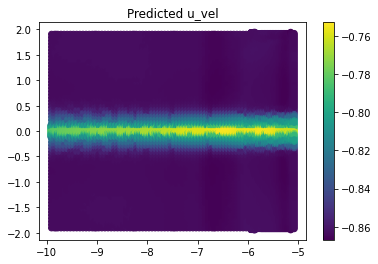

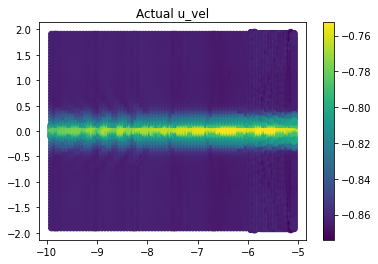

In [21]:
cep(model,True)

# Start the training for the next timesegments

In [23]:
if __name__ == "__main__":

    
    N_train = 25000
    batch_size=1000
    Reynolds = 100
    layers = [3]+10*[100]+[3]
    
    fre = 5
    
    # Timesteps for loop :
    datalist=load_complete_data()
    timesteps=[round(i,3) for i in np.arange(2,8,1)]
    
    # Copy and paste this api key: 822244d22c29151b0b6501c81c4e22a5c5a0843f
#     !wandb login --relogin

    # Starting a new run for every timestep
#     wandb.run.finish()
    entity_name="vamsi_malineni6"
    project_name="bc_pinn_ltd_0.1data_longer_training"
#     wandb.init(reinit=True)

        
    for i in timesteps:
        
        time_step = i
        
        # initializing wandb workspace
        wandb.init(entity=entity_name,project=project_name)
        
        # naming the run on wandb
        name_run= str(time_step)
        wandb.run.name=name_run
        
        # Loading the initial and the boundary conditions for the next timestep
        domain, initial, boundary, domain_data = load_data(time_step)

        # Loading the predictions of the final timestep of the first timesegment as the initial conditions of this time segment
        prediction_file='uv_preds_lts_exp41'
        u,v,t=read_uv_values(prediction_file)

        # Initial condition guided learning
        # Altering the initial conditions data, only uvt values are changed pressure values are untouched.
        initial[:,2]=t[:,0]
        initial[:,3]=u[:,0]
        initial[:,4]=v[:,0]

        # Loading the previous timesegment data
        prev_name='prev_data_predictions_lts_exp41'
        prevtimedata=read_prev_data(prev_name)

        # Enter the names of the files :
        '''
        params_name : name of the file where you want to save the weights and biases, LOAD THE MODEL EVERYTIME, SINCE ITS THE SAME
                      MODEL THAT IS BEING TRAINED OVER DIFFERNT TIMESEGMENTS, WITH FOCUS ON PREV TIME SEGMENTS                  
        loss_name   : name of the file where you want to save the loss components
        prev_name   : name of the file where you want to save the predictions of each time step in the segment
        '''

        params_name = 'params_exp41'
        loss_name   = 'Loss_re100_truly_sparse'

        # Start the Training process
        with tf.device('/gpu:0'):

            bc_pinn_model = bc_pinn_t (domain,initial,boundary,domain_data,prevtimedata,datalist,
                                       N_train,batch_size,
                                       layers,re=Reynolds,
                                       load_model=True,filedr=params_name,
                                       freeze = fre,timestep=time_step,
                                       savewandb=params_name,saveloss=loss_name)

            print("===============================================================================================")
            print("Commencing training for the timesegment:(",round((time_step-1),3),time_step,"] ")
            print("===============================================================================================")
            
            bc_pinn_model.Adam_train(1000, 1e-3)
            bc_pinn_model.Adam_train(1000, 1e-4)

        # Save the predictions of the final timestep of the current timesegment to be used for ICGL
        pred_file='uv_preds_lts_exp41'
        save_uv_values(bc_pinn_model,pred_file,time_step)

        # This code snippet appends the predictions at each time step for the previous time segment.
        idx=return_indexes(time_step)
        save_prev_data(idx,prev_name,time_step,bc_pinn_model)
        

        # Save the experiment run and finish the experiment in wandb 
        wandb.run.save()
        wandb.run.finish()


Boundary_loss,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Data_loss,█▃▃▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Initial_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,▆██▆▆▃▅▅▆▅▄▃▄▅▅▄▄▄▄▃▂▃▂▂▂▂▂▂▂▂▃▃▂▁▂▂▁▁▁▁
Total_loss,█▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,██▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
time step 2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▆▇▇██
time step 3,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▅▆▇▇▇███
time step 4,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇████
time step 5,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇████
time step 6,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇████


Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 1 2 ] 
epochs: 0, Loss: 3.695e-01, Time: 9.84
epochs: 10, Loss: 7.288e-02, Time: 26.77
Parameters are saved in pickle file
epochs: 20, Loss: 4.908e-02, Time: 27.49
Parameters are saved in pickle file
epochs: 30, Loss: 3.119e-02, Time: 26.83
Parameters are saved in pickle file
epochs: 40, Loss: 1.910e-02, Time: 27.10
Parameters are saved in pickle file
epochs: 50, Loss: 1.119e-02, Time: 27.43
Parameters are saved in pickle file
epochs: 60, Loss: 1.108e-02, Time: 25.56
Parameters are saved in pickle file
epochs: 70, Loss: 1.048e-02, Time: 25.39
Parame

epochs: 980, Loss: 2.654e-03, Time: 26.06
Parameters are saved in pickle file
epochs: 990, Loss: 2.604e-03, Time: 26.09
Parameters are saved in pickle file
epochs: 0, Loss: 6.647e-04, Time: 2.55
epochs: 10, Loss: 6.609e-04, Time: 25.75
Parameters are saved in pickle file
epochs: 20, Loss: 5.215e-04, Time: 25.59
Parameters are saved in pickle file
epochs: 30, Loss: 5.971e-04, Time: 25.31
Parameters are saved in pickle file
epochs: 40, Loss: 5.838e-04, Time: 25.14
Parameters are saved in pickle file
epochs: 50, Loss: 5.525e-04, Time: 25.68
Parameters are saved in pickle file
epochs: 60, Loss: 5.709e-04, Time: 25.18
Parameters are saved in pickle file
epochs: 70, Loss: 5.477e-04, Time: 25.09
Parameters are saved in pickle file
epochs: 80, Loss: 5.892e-04, Time: 25.61
Parameters are saved in pickle file
epochs: 90, Loss: 5.674e-04, Time: 25.86
Parameters are saved in pickle file
epochs: 100, Loss: 5.344e-04, Time: 26.82
Parameters are saved in pickle file
epochs: 110, Loss: 5.892e-04, Time

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Previous predictions are saved in pickle file


Boundary_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Data_loss,█▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Initial_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Previous_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 2,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 3,▁█▆▄▃▃▁▁▁▁▃▄▅▆▆▆▇▆▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃
time step 4,▃▂▁▁▁▁▁▁▂▃▄▆▇▇▇▇████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄
time step 5,▂▂▁▁▁▁▁▁▂▃▅▆▇▇▇▇▇██████▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄


Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 2 3 ] 
epochs: 0, Loss: 1.286e-01, Time: 9.53
epochs: 10, Loss: 2.333e-02, Time: 26.88
Parameters are saved in pickle file
epochs: 20, Loss: 8.652e-03, Time: 27.92
Parameters are saved in pickle file
epochs: 30, Loss: 7.563e-03, Time: 27.38
Parameters are saved in pickle file
epochs: 40, Loss: 4.647e-03, Time: 27.67
Parameters are saved in pickle file
epochs: 50, Loss: 4.195e-03, Time: 27.41
Parameters are saved in pickle file
epochs: 60, Loss: 3.508e-03, Time: 26.70
Parameters are saved in pickle file
epochs: 70, Loss: 4.599e-03, Time: 27.78
Parame

epochs: 980, Loss: 1.026e-03, Time: 26.57
Parameters are saved in pickle file
epochs: 990, Loss: 2.607e-03, Time: 26.51
Parameters are saved in pickle file
epochs: 0, Loss: 6.504e-04, Time: 2.60
epochs: 10, Loss: 4.923e-04, Time: 26.54
Parameters are saved in pickle file
epochs: 20, Loss: 5.127e-04, Time: 27.13
Parameters are saved in pickle file
epochs: 30, Loss: 5.612e-04, Time: 26.61
Parameters are saved in pickle file
epochs: 40, Loss: 5.043e-04, Time: 26.99
Parameters are saved in pickle file
epochs: 50, Loss: 4.665e-04, Time: 25.96
Parameters are saved in pickle file
epochs: 60, Loss: 4.696e-04, Time: 26.06
Parameters are saved in pickle file
epochs: 70, Loss: 4.804e-04, Time: 26.74
Parameters are saved in pickle file
epochs: 80, Loss: 4.465e-04, Time: 27.24
Parameters are saved in pickle file
epochs: 90, Loss: 4.404e-04, Time: 26.51
Parameters are saved in pickle file
epochs: 100, Loss: 4.287e-04, Time: 26.69
Parameters are saved in pickle file
epochs: 110, Loss: 5.001e-04, Time

Boundary_loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Data_loss,█▃▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Initial_loss,█▅▃▂▁▂▁▂▂▂▂▁▂▂▂▂▁▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Previous_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,█▅▆▂▃▃▃▂▃▄▄▂▄▅▃▄▃▅▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,█▂▂▂▁▂▂▁▂▂▂▁▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 2,█▃▂▁▁▂▁▁▁▁▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂
time step 3,█▄▃▃▃▂▂▂▃▃▃▂▃▃▂▃▂▇▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 4,▁█▇▇▇▇▆▅▆▅▅▄▄▄▅▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
time step 5,▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁█▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄


Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 3 4 ] 
epochs: 0, Loss: 1.093e-01, Time: 9.44
epochs: 10, Loss: 1.022e-02, Time: 26.57
Parameters are saved in pickle file
epochs: 20, Loss: 5.536e-03, Time: 27.99
Parameters are saved in pickle file
epochs: 30, Loss: 3.651e-03, Time: 27.37
Parameters are saved in pickle file
epochs: 40, Loss: 4.459e-03, Time: 27.77
Parameters are saved in pickle file
epochs: 50, Loss: 2.890e-03, Time: 28.95
Parameters are saved in pickle file
epochs: 60, Loss: 3.216e-03, Time: 28.08
Parameters are saved in pickle file
epochs: 70, Loss: 4.007e-03, Time: 27.69
Parame

epochs: 980, Loss: 1.285e-03, Time: 27.89
Parameters are saved in pickle file
epochs: 990, Loss: 1.127e-03, Time: 27.52
Parameters are saved in pickle file
epochs: 0, Loss: 5.340e-04, Time: 2.70
epochs: 10, Loss: 4.588e-04, Time: 26.48
Parameters are saved in pickle file
epochs: 20, Loss: 4.679e-04, Time: 26.60
Parameters are saved in pickle file
epochs: 30, Loss: 4.593e-04, Time: 26.39
Parameters are saved in pickle file
epochs: 40, Loss: 4.256e-04, Time: 26.82
Parameters are saved in pickle file
epochs: 50, Loss: 4.453e-04, Time: 26.59
Parameters are saved in pickle file
epochs: 60, Loss: 4.140e-04, Time: 26.14
Parameters are saved in pickle file
epochs: 70, Loss: 4.466e-04, Time: 26.17
Parameters are saved in pickle file
epochs: 80, Loss: 4.456e-04, Time: 26.28
Parameters are saved in pickle file
epochs: 90, Loss: 4.219e-04, Time: 26.59
Parameters are saved in pickle file
epochs: 100, Loss: 4.212e-04, Time: 26.40
Parameters are saved in pickle file
epochs: 110, Loss: 4.182e-04, Time

Boundary_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Data_loss,█▂▃▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Initial_loss,█▄▃▃▃▂▂▂▂▂▂▃▃▃▁▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Previous_loss,█▂▂▂▂▂▄▃▂▃▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,█▅▅█▆▃▂▃▄▅▃▄▇▇▃█▃▅▃▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,█▃▃▃▃▂▃▂▂▃▂▂▃▃▂▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▂▁▂▁▁▃▂▂▃▁▁▂▁▁▂▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 2,█▃▂▂▂▂▂▃▃▅▂▂▃▃▁▃▃▄▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 3,█▂▂▁▃▂▂▁▂▁▂▂▁▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 4,█▅▄▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 5,██▇▇▆▅▄▄▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃


Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 4 5 ] 
epochs: 0, Loss: 1.092e-01, Time: 10.13
epochs: 10, Loss: 9.594e-03, Time: 27.94
Parameters are saved in pickle file
epochs: 20, Loss: 5.642e-03, Time: 28.81
Parameters are saved in pickle file
epochs: 30, Loss: 5.828e-03, Time: 26.95
Parameters are saved in pickle file
epochs: 40, Loss: 5.257e-03, Time: 27.24
Parameters are saved in pickle file
epochs: 50, Loss: 4.030e-03, Time: 26.70
Parameters are saved in pickle file
epochs: 60, Loss: 4.884e-03, Time: 26.97
Parameters are saved in pickle file
epochs: 70, Loss: 3.419e-03, Time: 27.03
Param

epochs: 980, Loss: 2.453e-03, Time: 27.01
Parameters are saved in pickle file
epochs: 990, Loss: 2.772e-03, Time: 27.34
Parameters are saved in pickle file
epochs: 0, Loss: 1.406e-03, Time: 2.67
epochs: 10, Loss: 1.083e-03, Time: 27.03
Parameters are saved in pickle file
epochs: 20, Loss: 1.276e-03, Time: 26.71
Parameters are saved in pickle file
epochs: 30, Loss: 1.299e-03, Time: 26.92
Parameters are saved in pickle file
epochs: 40, Loss: 1.690e-03, Time: 26.88
Parameters are saved in pickle file
epochs: 50, Loss: 1.674e-03, Time: 28.74
Parameters are saved in pickle file
epochs: 60, Loss: 1.194e-03, Time: 28.96
Parameters are saved in pickle file
epochs: 70, Loss: 1.552e-03, Time: 28.89
Parameters are saved in pickle file
epochs: 80, Loss: 1.150e-03, Time: 28.64
Parameters are saved in pickle file
epochs: 90, Loss: 1.317e-03, Time: 28.66
Parameters are saved in pickle file
epochs: 100, Loss: 1.614e-03, Time: 29.05
Parameters are saved in pickle file
epochs: 110, Loss: 1.253e-03, Time

Boundary_loss,▃▂▁▁▁▁▁▁▁▁▁▁█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Data_loss,▂▁▁▁▁▁▁▁▁▁▁▁█▅▃▁▃▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Initial_loss,▂▁▁▁▁▂▁▁▁▁▁▁█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Previous_loss,█▃▄▄▃▂▂▂▂▂▁▁▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,▃▂▂▃▂▄▂▂▂▂▂▂█▃▃▄▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,▄▂▂▂▂▂▁▂▂▁▁▁█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▃▃▃▂▁▁▂▁▂▁▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 2,█▄▃▂▂▂▂▂▂▂▂▁▄▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 3,█▃▄▃▂▄▃▃▄▁▂▁▇▃▃▃▂▄▂▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 4,▄▂▂▂▂▂▁▂▂▂▁▁█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 5,▃▁▁▁▁▁▁▁▁▁▁▁█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂


Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 5 6 ] 
epochs: 0, Loss: 1.079e-01, Time: 9.73
epochs: 10, Loss: 1.625e-02, Time: 27.33
Parameters are saved in pickle file
epochs: 20, Loss: 7.271e-03, Time: 28.80
Parameters are saved in pickle file
epochs: 30, Loss: 6.885e-03, Time: 26.97
Parameters are saved in pickle file
epochs: 40, Loss: 5.011e-03, Time: 27.54
Parameters are saved in pickle file
epochs: 50, Loss: 6.258e-03, Time: 28.22
Parameters are saved in pickle file
epochs: 60, Loss: 4.840e-03, Time: 27.69
Parameters are saved in pickle file
epochs: 70, Loss: 4.858e-03, Time: 27.10
Parame

epochs: 980, Loss: 1.786e-02, Time: 27.83
Parameters are saved in pickle file
epochs: 990, Loss: 5.950e-03, Time: 27.41
Parameters are saved in pickle file
epochs: 0, Loss: 4.100e-03, Time: 2.74
epochs: 10, Loss: 6.746e-03, Time: 27.57
Parameters are saved in pickle file
epochs: 20, Loss: 2.003e-03, Time: 27.26
Parameters are saved in pickle file
epochs: 30, Loss: 3.351e-03, Time: 27.16
Parameters are saved in pickle file
epochs: 40, Loss: 3.765e-03, Time: 26.92
Parameters are saved in pickle file
epochs: 50, Loss: 2.314e-03, Time: 27.57
Parameters are saved in pickle file
epochs: 60, Loss: 2.047e-03, Time: 27.43
Parameters are saved in pickle file
epochs: 70, Loss: 2.036e-03, Time: 27.50
Parameters are saved in pickle file
epochs: 80, Loss: 2.217e-03, Time: 27.27
Parameters are saved in pickle file
epochs: 90, Loss: 2.787e-03, Time: 27.31
Parameters are saved in pickle file
epochs: 100, Loss: 2.169e-03, Time: 27.43
Parameters are saved in pickle file
epochs: 110, Loss: 2.627e-03, Time

Boundary_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Data_loss,▄▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Initial_loss,█▃▂▃▂▂▃▂▂▂▁▁▁▁▃▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Previous_loss,█▃▂▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,▇▄▅█▄▃▅▄▃█▃▂▂▂▃▂▂▄▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,█▄▃▄▂▂▃▂▂▃▂▁▂▁▂▂▁▂▁▂▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▃▂▃▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 2,█▄▃▄▂▃▃▂▃▂▄▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 3,▆▄▃▃▂▂▃▂▄▃█▂▃▂▂▄▂▂▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 4,▆▄▂▄▂▁▁▁▄▂▇▂▂▂▅█▂▃▂▃▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 5,█▄▃▄▂▂▂▂▂▃▂▁▁▂▅▃▂▄▂▂▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂


Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 6 7 ] 
epochs: 0, Loss: 9.880e-02, Time: 10.00
epochs: 10, Loss: 9.095e-03, Time: 27.78
Parameters are saved in pickle file
epochs: 20, Loss: 7.691e-03, Time: 31.08
Parameters are saved in pickle file
epochs: 30, Loss: 9.534e-03, Time: 29.62
Parameters are saved in pickle file
epochs: 40, Loss: 7.765e-03, Time: 29.33
Parameters are saved in pickle file
epochs: 50, Loss: 8.491e-03, Time: 29.84
Parameters are saved in pickle file
epochs: 60, Loss: 5.410e-03, Time: 29.40
Parameters are saved in pickle file
epochs: 70, Loss: 6.943e-03, Time: 29.72
Param

epochs: 980, Loss: 1.494e-03, Time: 28.98
Parameters are saved in pickle file
epochs: 990, Loss: 3.053e-03, Time: 29.10
Parameters are saved in pickle file
epochs: 0, Loss: 8.899e-04, Time: 2.89
epochs: 10, Loss: 7.662e-04, Time: 28.83
Parameters are saved in pickle file
epochs: 20, Loss: 7.527e-04, Time: 28.69
Parameters are saved in pickle file
epochs: 30, Loss: 7.836e-04, Time: 27.97
Parameters are saved in pickle file
epochs: 40, Loss: 7.326e-04, Time: 28.37
Parameters are saved in pickle file
epochs: 50, Loss: 7.146e-04, Time: 28.29
Parameters are saved in pickle file
epochs: 60, Loss: 7.149e-04, Time: 27.98
Parameters are saved in pickle file
epochs: 70, Loss: 7.863e-04, Time: 28.12
Parameters are saved in pickle file
epochs: 80, Loss: 7.121e-04, Time: 28.05
Parameters are saved in pickle file
epochs: 90, Loss: 7.538e-04, Time: 28.03
Parameters are saved in pickle file
epochs: 100, Loss: 7.622e-04, Time: 27.72
Parameters are saved in pickle file
epochs: 110, Loss: 7.198e-04, Time

Boundary_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Data_loss,▄█▄▂▅▂▂▂▂▂▂▃▂▃▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Initial_loss,█▄▃▃▃▂▂▂▅▂▄▂▁▃▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Previous_loss,▇█▅▄█▂▂▂▂▅▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,█▆█▇▄▅▃▅▃▄▅▄▄▇▂▄▃▄▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,██▆▅▆▃▂▃▂▄▃▃▃▄▂▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▅▃▂▄▂▂▂▂▃▂▁▁▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 2,▆█▆▄█▂▃▃▂▆▃▂▂▃▂▃▂▂▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 3,▅▅▅▆█▃▂▂▂▅▂▄▂▃▂▄▂▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 4,▅▂▃▅█▂▁▂▁▆▇▇▃▄▄▄▂▆▄▄▁▁▁▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁
time step 5,▅▂▇▄▃▃▄▃▂▅▇█▃▆▄▆▂▅▇▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


# Run this code snippet to load the model 

In [14]:
'''
This code snippet loads the bc pinn model, for some reason its not predicting well for time t=0 ?
'''

if __name__ == "__main__":

    
    N_train = 25000
    batch_size=1000
    Reynolds = 100
    layers = [3]+10*[100]+[3]
    
    # Enter the latest timestep for which the model has be previous trained on.
    time_step_test = 7

    # Loading the initial and the boundary conditions for the next timestep
    domain, initial, boundary,domain_data = load_data(time_step_test)
    datalist=load_complete_data()


    # Loading the predictions of the final timestep of the first timesegment as the initial conditions of this time segment
    prediction_file='uv_preds_lts_exp20'
    u,v,t=read_uv_values(prediction_file)

    # Initial condition guided learning
    # Altering the initial conditions data, only uvt values are changed pressure values are untouched.
    initial[:,2]=t[:,0]
    initial[:,3]=u[:,0]
    initial[:,4]=v[:,0]

    # Loading the previous timesegment data
    prev_name='prev_data_predictions_lts_exp20'
    prevtimedata=read_prev_data(prev_name)

    # Enter the names of the files :
    '''
    params_name : name of the file where you want to save the weights and biases, LOAD THE MODEL EVERYTIME, SINCE ITS THE SAME
                  MODEL THAT IS BEING TRAINED OVER DIFFERNT TIMESEGMENTS, WITH FOCUS ON PREV TIME SEGMENTS                  
    loss_name   : name of the file where you want to save the loss components
    prev_name   : name of the file where you want to save the predictions of each time step in the segment
    '''

    params_name = 'params_exp20'
    loss_name   = 'Loss_re100_truly_sparse'

    # Start the Training process
    with tf.device('/gpu:0'):

        bc_pinn_model_test = bc_pinn_t (domain,initial,boundary,domain_data,prevtimedata,datalist,
                                       N_train,batch_size,
                                       layers,re=Reynolds,
                                       load_model=True,filedr=params_name,
                                       freeze = 5,timestep=time_step_test,
                                       savewandb=params_name,saveloss=loss_name)

Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6



# Run this code snippet for checking

In [27]:
# Run this for Prediction for a network of 3 10*100 3 
def test_check_predictions(test_time_step,model,plot=False):
    '''
    This code works for specific time steps like 0,1,2,.... and not for intermediate timesteps like 0.1,0.2,0.3......
    '''

    X_star,Y_star=load_testdata(test_time_step)
    u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])

    # # Error
    error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
    error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)

    # Mean corrected pressure error
    p_predm=p_pred-np.mean(p_pred)
    p_truem=Y_star[2]-np.mean(Y_star[2])

    error_p = np.linalg.norm(p_truem - p_predm, 2) / np.linalg.norm(p_truem, 2)

    print("Errors at timestep:", np.unique(X_star[2]))
    print("------------------------------------------------")
    print('Error u: %e' % error_u)
    print('Error v: %e' % error_v)
    print('Error p: %e' % error_p)
    
    if plot == True:
        uplot=np.reshape(u_pred,(100,100))
        plt.imshow(uplot)
        plt.title("Predicted v_velocity")
        plt.colorbar()
        plt.savefig('pred'+str(test_time_step))
        plt.show()

        upl=np.reshape(Y_star[0],(100,100))
        plt.imshow(upl)
        plt.title("Actual v_velocity")
        plt.colorbar()
        plt.savefig('actual'+str(test_time_step))
        plt.show()
    return error_u,error_v

Errors at timestep: [0.]
------------------------------------------------
Error u: 1.286600e-02
Error v: 6.551542e-02
Error p: 6.837573e+00


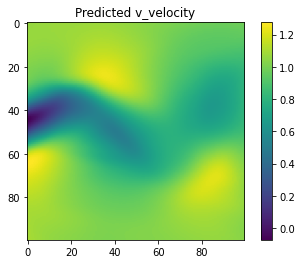

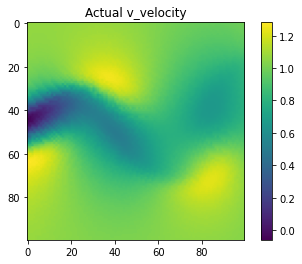

Errors at timestep: [1.]
------------------------------------------------
Error u: 3.141168e-02
Error v: 1.568716e-01
Error p: 3.735211e+00


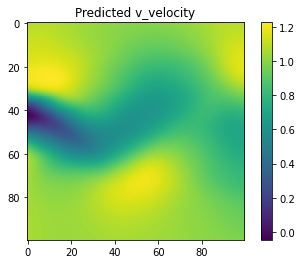

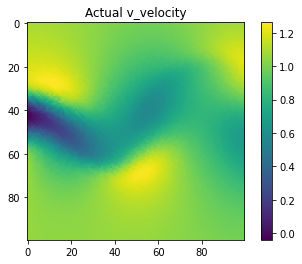

Errors at timestep: [2.]
------------------------------------------------
Error u: 2.430183e-02
Error v: 9.927386e-02
Error p: 6.290474e+00


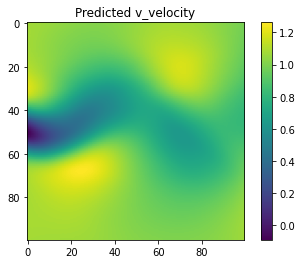

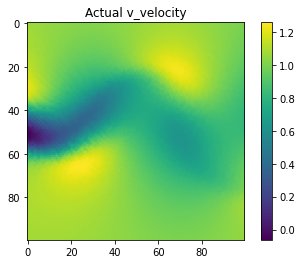

Errors at timestep: [3.]
------------------------------------------------
Error u: 2.353588e-02
Error v: 1.522240e-01
Error p: 2.093243e+00


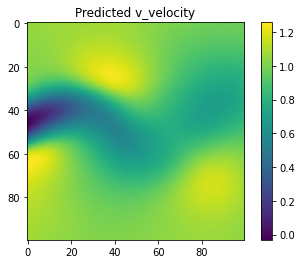

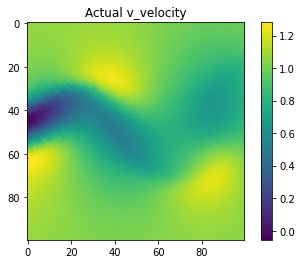

Errors at timestep: [4.]
------------------------------------------------
Error u: 2.390267e-02
Error v: 1.105691e-01
Error p: 1.349598e+00


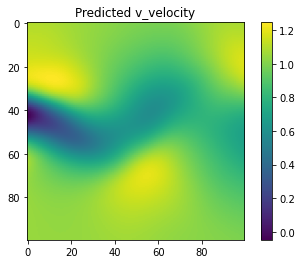

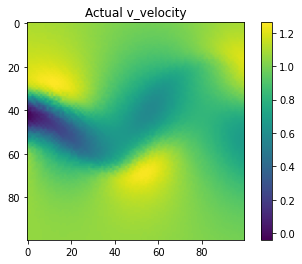

Errors at timestep: [5.]
------------------------------------------------
Error u: 2.202370e-02
Error v: 1.242383e-01
Error p: 5.197058e+00


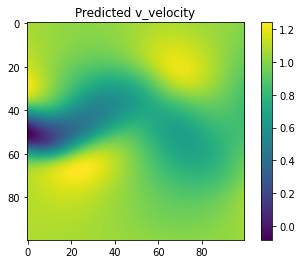

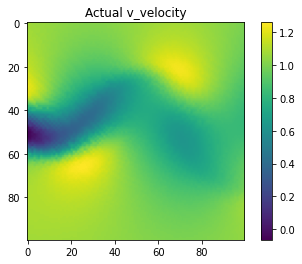

Errors at timestep: [6.]
------------------------------------------------
Error u: 2.797917e-02
Error v: 1.555835e-01
Error p: 6.458689e-01


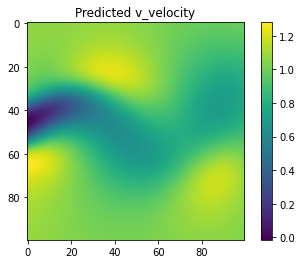

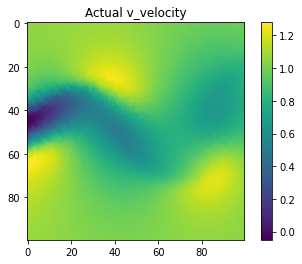

Errors at timestep: [7.]
------------------------------------------------
Error u: 2.700173e-02
Error v: 9.952743e-02
Error p: 2.394519e-01


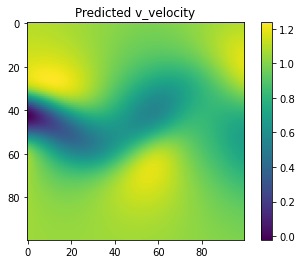

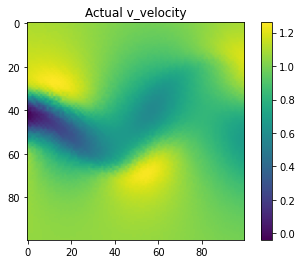

In [33]:
eu=[]
ev=[]
for i in np.arange(0,8,1):
    eua,eva=test_check_predictions(round(i,3),bc_pinn_model,plot=True)
    eu.append(eua)
    ev.append(eva)

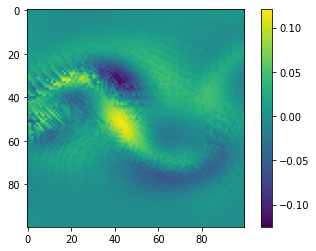

In [32]:
X_star,Y_star=load_testdata(6)
u_pred, v_pred, p_pred = bc_pinn_model.predict(X_star[0],X_star[1],X_star[2])
err=u_pred-Y_star[0]
err=np.reshape(err,(100,100))

plt.imshow(err)
plt.colorbar()


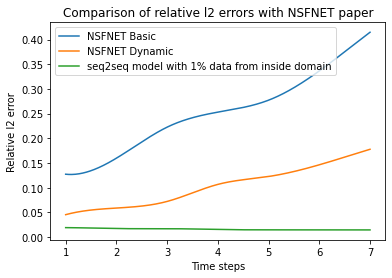

In [17]:
from scipy.interpolate import make_interp_spline as mis

nsfdata=pd.read_csv(r"C:\Users\user1\Desktop\NSFNET_basic.csv").to_numpy()
nsfdata2=pd.read_csv(r"C:\Users\user1\Desktop\NSFNET_dynamic.csv").to_numpy()
for i in range(nsfdata.shape[1]):
    nsfdata[i,0]=round(nsfdata[i,0],3)
    
for i in range(nsfdata2.shape[1]):
    nsfdata2[i,0]=round(nsfdata2[i,0],3)

t_nsf=nsfdata[:,0]
eu_nsf=nsfdata[:,1]
eu_nsf2=nsfdata2[:,1]

# Basic 
xyspline=mis(t_nsf,eu_nsf)
x=np.linspace(t_nsf.min(),t_nsf.max(),500)
y=xyspline(x)
plt.plot(x,y)
# Dynamic weights
xyspline3=mis(t_nsf,eu_nsf2)
y3=xyspline3(x)
plt.plot(x,y3)

# MY model
t=[i for i in np.arange(0,8,1)]
xyspline2=mis(t,eu)
y2=xyspline2(x)
plt.plot(x,y2)

plt.legend(['NSFNET Basic','NSFNET Dynamic','seq2seq model with 1% data from inside domain'])
plt.title("Comparison of relative l2 errors with NSFNET paper")
plt.xlabel("Time steps")
plt.ylabel("Relative l2 error")
plt.show()

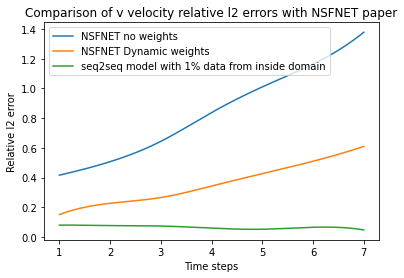

In [18]:
from scipy.interpolate import make_interp_spline as mis

nsfdatav=pd.read_csv(r"C:\Users\user1\Desktop\vvel_basic.csv").to_numpy()
nsfdatav2=pd.read_csv(r"C:\Users\user1\Desktop\vvel_dynamic.csv").to_numpy()
for i in range(nsfdatav.shape[1]):
    nsfdatav[i,0]=round(nsfdatav[i,0],3)
    
for i in range(nsfdatav2.shape[1]):
    nsfdatav2[i,0]=round(nsfdatav2[i,0],3)

t_nsf=nsfdatav[:,0]
eu_nsf=nsfdatav[:,1]
eu_nsf2=nsfdatav2[:,1]

# Basic 
xyspline=mis(t_nsf,eu_nsf)
x=np.linspace(t_nsf.min(),t_nsf.max(),500)
y=xyspline(x)
plt.plot(x,y)
# Dynamic weights
xyspline3=mis(t_nsf,eu_nsf2)
y3=xyspline3(x)
plt.plot(x,y3)

# MY model
t=[i for i in np.arange(0,8,1)]
xyspline2=mis(t,ev)
y2=xyspline2(x)
plt.plot(x,y2)

plt.legend(['NSFNET no weights','NSFNET Dynamic weights','seq2seq model with 1% data from inside domain'])
plt.title("Comparison of v velocity relative l2 errors with NSFNET paper")
plt.xlabel("Time steps")
plt.ylabel("Relative l2 error")
plt.show()

# Run this code segment to save the errors


In [29]:
def save_error_data(file_name,eu):
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\RE100_mts_results\novel_method")
    my_path=root_path/file_name

    with open(my_path,'wb') as f:
        pickle.dump(eu,f)
        print("Errors are saved in pickle file")


In [30]:
def load_error_data(file_name):
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_results\novel_method")
    my_path=root_path/file_name

    # returns the weights and biases of the network as np array
    with open(my_path,'rb') as f:
        eu_load=pickle.load(f)
    return eu_load

# Saving the errors

In [31]:
save_error_data('0.1data_long_training',eu)

Errors are saved in pickle file
